Checking if M507 works correctly

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
from wind_tools import *  
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib
#matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt
sns.set()
import plotly.express as px

matplotlib.rcParams['figure.figsize'] = (16,10)

In [ ]:
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

In [ ]:
from functools import partial
# monkey patching from_euler to avoid forgetting adding degrees=True
R.from_euler = partial(R.from_euler, degrees=True)

## Load data

In [ ]:
proc_dir = Path("2020_data/data_20200724_final_field_install/processed")

# default is 2 mins aggregated data
wm1_path = proc_dir / "eddypro_WM1_2min_full_output_2020-08-01T085655_exp.csv"
# raw data no rotation nor axis renaming on it
m7rw_path = proc_dir / "eddypro_TRS_M507_raw_full_output_2020-07-31T185919_exp.csv"
m7_path = proc_dir / "eddypro_TRS_M507_full_output_2020-07-30T173800_exp.csv"



cache_dir = Path("data_cache")
start_date = '2020-07-24 13:00:00'
end_date = '2020-07-31 18:00:00'

wind_cols = ['u_unrot','v_unrot', 'w_unrot', 'wind_speed', 'wind_dir']
wind_comp_rename = {'u_unrot': 'u', 'v_unrot': 'v', 'w_unrot': 'w'}

In [ ]:
wm1, m7rw, m7= map(
    lambda p: load_ep_cache(p, cache_dir= cache_dir)
    .loc[start_date:end_date]
    .loc[:,wind_cols]
    .rename(columns=wind_comp_rename),
    [wm1_path, m7rw_path, m7_path])

In [ ]:
wm1 = wm1.interpolate()

In [ ]:
wm1r = rotate_wind_ang(wm1, 310)
wm1r = add_hor_wind_speed(wm1r)

In [ ]:
filt = filter_by_wind_dir(wm1r, 250, 10)

wm1f = wm1r[filt]

m7f =m7rw[filt]

In [ ]:
m7rw.describe()

,u,v,w,wind_speed,wind_dir
count,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000
mean,-0.137268,-0.153541,0.219262,0.901094,118.302068
std,0.919960,0.539818,0.125435,0.657291,98.515126
min,-2.859030,-2.152510,-0.032108,0.033174,0.099878
25%,-0.913690,-0.541447,0.119908,0.386045,31.136975
50%,0.154537,0.028925,0.198659,0.703252,63.642550
75%,0.480652,0.213446,0.297619,1.299918,196.072000
max,3.020720,1.541330,1.026130,3.393000,359.985000


In [ ]:
wm1r.describe()

,u,v,w,wind_speed,wind_dir
count,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000
mean,-0.387331,0.136753,0.016714,1.009122,183.171265
std,1.034580,0.512729,0.118185,0.705583,115.487540
min,-3.452527,-1.442855,-0.523442,0.024813,0.067376
25%,-1.269374,-0.210656,-0.046327,0.428207,69.182800
50%,0.011694,0.064848,0.018517,0.819560,155.778500
75%,0.349301,0.418239,0.085315,1.494757,304.800750
max,2.085213,3.008783,0.619600,3.527280,359.690000


In [ ]:
m7.describe()

,u,v,w,wind_speed,wind_dir
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,-0.090440,0.214519,-0.018928,0.918277,265.030948
std,0.346608,0.119903,1.010124,0.601838,91.078578
min,-1.316930,-0.032108,-3.023360,0.039933,0.051559
25%,-0.316158,0.120061,-0.753708,0.445591,261.841250
50%,-0.102362,0.196345,0.310267,0.781380,278.096000
75%,0.129877,0.289974,0.656060,1.295552,316.692000
max,1.193280,0.914108,2.492670,3.043640,359.905000


In [ ]:
u, v, w = 0,1,2

data = m7rw[['u','v','w']].to_numpy()
data

array([[-1.2396  , -0.705321,  0.404499],
       [-1.497   , -0.661067,  0.371917],
       [-1.47419 , -0.618917,  0.3504  ],
       ...,
       [-2.41187 , -1.52548 ,  0.5221  ],
       [-1.38551 , -0.777808,  0.385542],
       [-0.917842, -0.665492,  0.269242]])

In [ ]:
data[:, [u, v]] = rotate_ang(data[:, [u,v]], 45); data

array([[-0.3777923 , -1.37526683,  0.404499  ],
       [-0.59109389, -1.52598381,  0.371917  ],
       [-0.60476934, -1.48005015,  0.3504    ],
       ...,
       [-0.62677238, -2.78412688,  0.5221    ],
       [-0.42971021, -1.52969683,  0.385542  ],
       [-0.1784384 , -1.11958621,  0.269242  ]])

In [ ]:
data[:, u] = -1 * data[:, u] ; data

array([[ 1.2396  , -0.705321,  0.404499],
       [ 1.497   , -0.661067,  0.371917],
       [ 1.47419 , -0.618917,  0.3504  ],
       ...,
       [ 2.41187 , -1.52548 ,  0.5221  ],
       [ 1.38551 , -0.777808,  0.385542],
       [ 0.917842, -0.665492,  0.269242]])

In [ ]:
data[:, v] = data[:, w]; data

array([[-0.3777923 ,  0.404499  ,  0.404499  ],
       [-0.59109389,  0.371917  ,  0.371917  ],
       [-0.60476934,  0.3504    ,  0.3504    ],
       ...,
       [-0.62677238,  0.5221    ,  0.5221    ],
       [-0.42971021,  0.385542  ,  0.385542  ],
       [-0.1784384 ,  0.269242  ,  0.269242  ]])

In [ ]:
data[:, w] = data[:, v]; data

In [ ]:
data

array([[0.3777923 , 0.404499  , 0.404499  ],
       [0.59109389, 0.371917  , 0.371917  ],
       [0.60476934, 0.3504    , 0.3504    ],
       ...,
       [0.62677238, 0.5221    , 0.5221    ],
       [0.42971021, 0.385542  , 0.385542  ],
       [0.1784384 , 0.269242  , 0.269242  ]])

In [ ]:
m7

,u,v,w,wind_speed,wind_dir
date_time,,,,,
2020-07-24 13:02:00,0.378782,0.405271,0.404499,0.686109,348.58900
2020-07-24 13:04:00,0.590608,0.371608,0.371917,0.790717,8.39932
2020-07-24 13:06:00,0.605992,0.350400,0.350400,0.782807,6.34241
2020-07-24 13:08:00,0.510633,0.355717,0.355717,0.716809,4.13368
2020-07-24 13:10:00,0.843400,0.347371,0.346600,0.975767,16.48800
...,...,...,...,...,...
2020-07-28 14:52:00,0.040225,0.188875,0.188458,0.269830,320.77900
2020-07-28 14:54:00,0.059417,0.129567,0.130350,0.193155,298.04400
2020-07-28 14:56:00,0.626342,0.522100,0.522100,0.968236,358.23400


## Exploration plots

In [ ]:
plot_components(resample([wm1, m7], '8min'),('wind_speed', ), plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# rotate
m7n1 = rotate_wind_ang(m7rw, 45)

In [ ]:
m7n1

,u,v,w,wind_speed,wind_dir
date_time,,,,,
2020-07-24 13:02:00,-0.377792,-1.375267,0.404499,1.48584,198.866
2020-07-24 13:04:00,-0.591094,-1.525984,0.371917,1.67819,206.139
2020-07-24 13:06:00,-0.604769,-1.480050,0.350400,1.63679,210.757
2020-07-24 13:08:00,-0.510680,-1.282133,0.355717,1.42520,202.391
2020-07-24 13:10:00,-0.844531,-1.473903,0.346600,1.73371,212.675
...,...,...,...,...,...
2020-07-28 14:52:00,-0.041154,-1.333674,0.188458,1.34755,185.038
2020-07-28 14:54:00,-0.059480,-1.179018,0.130350,1.18769,178.851
2020-07-28 14:56:00,-0.626772,-2.784127,0.522100,2.90117,196.496


In [ ]:
wind_speed_comp(m7n1, 'uv')

date_time
2020-07-24 13:02:00    1.426214
2020-07-24 13:04:00    1.636465
2020-07-24 13:06:00    1.598842
2020-07-24 13:08:00    1.380094
2020-07-24 13:10:00    1.698712
                         ...   
2020-07-28 14:52:00    1.334309
2020-07-28 14:54:00    1.180517
2020-07-28 14:56:00    2.853806
2020-07-28 14:58:00    1.588906
2020-07-28 15:00:00    1.133717
Length: 2940, dtype: float64

In [ ]:
wind_speed_comp(m7rw, 'uv')

date_time
2020-07-24 13:02:00    1.426214
2020-07-24 13:04:00    1.636465
2020-07-24 13:06:00    1.598842
2020-07-24 13:08:00    1.380094
2020-07-24 13:10:00    1.698712
                         ...   
2020-07-28 14:52:00    1.334309
2020-07-28 14:54:00    1.180517
2020-07-28 14:56:00    2.853806
2020-07-28 14:58:00    1.588906
2020-07-28 15:00:00    1.133717
Length: 2940, dtype: float64

okayyyy ce semo

In [ ]:
m7n = m7n1.copy()

In [ ]:
m7n.u = -m7n1.u
m7n.v = m7n1.w
m7n.w = m7n1.v

In [ ]:
m7

,u,v,w,wind_speed,wind_dir
date_time,,,,,
2020-07-24 13:02:00,0.378782,0.403054,-1.34807,1.45357,348.68300
2020-07-24 13:04:00,0.590608,0.371608,-1.52188,1.67370,8.39932
2020-07-24 13:06:00,0.605992,0.350400,-1.38413,1.54118,6.34241
2020-07-24 13:08:00,0.510633,0.355717,-1.27191,1.41591,4.13368
2020-07-24 13:10:00,0.843400,0.347371,-1.47499,1.73424,16.48800
...,...,...,...,...,...
2020-07-28 14:52:00,0.040225,0.188875,-1.33447,1.34837,320.77900
2020-07-28 14:54:00,0.059417,0.129567,-1.17914,1.18773,298.04400
2020-07-28 14:56:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
m7n

,u,v,w,wind_speed,wind_dir
date_time,,,,,
2020-07-24 13:02:00,0.377792,0.404499,-1.375267,1.48584,198.866
2020-07-24 13:04:00,0.591094,0.371917,-1.525984,1.67819,206.139
2020-07-24 13:06:00,0.604769,0.350400,-1.480050,1.63679,210.757
2020-07-24 13:08:00,0.510680,0.355717,-1.282133,1.42520,202.391
2020-07-24 13:10:00,0.844531,0.346600,-1.473903,1.73371,212.675
...,...,...,...,...,...
2020-07-28 14:52:00,0.041154,0.188458,-1.333674,1.34755,185.038
2020-07-28 14:54:00,0.059480,0.130350,-1.179018,1.18769,178.851
2020-07-28 14:56:00,0.626772,0.522100,-2.784127,2.90117,196.496


In [ ]:
plot_components(resample([wm1, m7n], '8min'),('wind_speed', 'u', 'v', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'u'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
plt.plot()

[]

In [ ]:
ax = get_ax()
wm1.v.plot(ax=ax)
m7n.w.plot(ax=ax)

/home/simone/Documents/Tesi/trisonica-anemometer-comparison/wind_tools.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  def get_ax(nrows=1, ncols=1): return plt.subplots(nrows, ncols)[1]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='date_time'>

strano ma é proprio la stessa cosa

In [ ]:
ax = get_ax()
wm1.w.plot(ax=ax)
m7n.u.plot(ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='date_time'>

but damn we have forgot to rotate, let's try this time

In [ ]:
wm1r = rotate_wind_ang(wm1, 310)

In [ ]:
l = []
for i in range(0,360,5):
    l.append((rotate_wind_ang(m7rw, i).u - wm1r.u).mean())

In [ ]:
get_ax(figsize=(5,3)).plot(l)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Quindi dopo questo sistema super scientifico ruotiamo di 250 e vediamo che esplode

In [ ]:
m7rwr = rotate_wind_ang(m7rw, 350)

In [ ]:
plot_components(resample([wm1r, m7rwr], '8min'),('wind_speed', 'u', 'v', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

NameError: name 'plot_components' is not defined

In [ ]:
plot_components(resample([wm1r, m7rwr], '8min'),('wind_speed', 'u', 'v', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'u'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
def round_df_to(df, to=5):
    return (df / to).round()*to

In [ ]:
wm1['wind_dir_round'] = round_df_to(wm1.wind_dir) 

In [ ]:
axes = plot_components(resample([wm1r, m7rwr], '8min'),('u', 'v', 'w', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)
axes[-1].cla()
wm1.wind_dir_round.plot.plot(ax=axes[-1])

NameError: name 'm7rwr' is not defined

In [ ]:
a

NameError: name 'a' is not defined

In [ ]:
ax = get_ax()
wm1.v.plot(ax=ax)
m7n1.v.plot(ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='date_time'>

# Okay this is craziness

In [ ]:
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

In [ ]:
import torch

In [ ]:
rot1 = torch.rand((2,2), dtype=torch.float64).requires_grad_(True)

In [ ]:
rot2 = torch.rand((2,2), dtype=torch.float64).requires_grad_(True)

In [ ]:
rot1p = torch.cat([torch.cat([rot1, torch.zeros((1,2), dtype=torch.float64)]),  torch.zeros((3,1), dtype=torch.float64)], dim=1)

In [ ]:
rot1p

tensor([[0.0839, 0.6545, 0.0000],
        [0.0131, 0.9502, 0.0000],
        [0.0000, 0.0000, 0.0000]], dtype=torch.float64, grad_fn=<CatBackward>)

In [ ]:
rot2p = torch.cat([torch.zeros((3,1), dtype=torch.float64), torch.cat([torch.zeros((1,2), dtype=torch.float64), rot2, ])], dim=1)

In [ ]:
rot2p

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.4892, 0.0193],
        [0.0000, 0.7147, 0.3371]], dtype=torch.float64, grad_fn=<CatBackward>)

In [ ]:
rot_mat = rot1p @ rot2p

In [ ]:
x

tensor([[-1.2396, -0.7053,  0.4045],
        [-1.4970, -0.6611,  0.3719],
        [-1.4742, -0.6189,  0.3504],
        ...,
        [-2.4119, -1.5255,  0.5221],
        [-1.3855, -0.7778,  0.3855],
        [-0.9178, -0.6655,  0.2692]], dtype=torch.float64)

In [ ]:
out = x@rot_mat

In [ ]:
out

tensor([[-0.5691, -0.6497, -1.2005],
        [-0.6205, -0.7079, -1.4410],
        [-0.5983, -0.6819, -1.4171],
        ...,
        [-1.3010, -1.5416, -2.3832],
        [-0.6559, -0.7581, -1.3481],
        [-0.5176, -0.6096, -0.9088]], dtype=torch.float64,
       grad_fn=<MmBackward>)

In [ ]:
(out - y_true).pow(2).mean()

tensor(0.4728, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
mse(out, y_true)

tensor(0.4728, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
x = torch.tensor(m7rw[['u', 'v', 'w']].to_numpy())

In [ ]:
y_true = torch.tensor(wm1[['u', 'v', 'w']].to_numpy())

In [ ]:
def model(x):
    return x@rot_mat

In [ ]:
rot_mat = torch.rand((3,3), dtype=torch.float64).requires_grad_(True)

In [ ]:
lr = .1
def update(x,y,lr):
    y_hat = model(x)
    loss = mse(y_hat, y) 
    loss.backward()
    with torch.no_grad():
        rot_mat.sub_(lr * rot_mat.grad)
        rot_mat.grad.zero_()
    return loss.item()

In [ ]:
losses = []

In [ ]:
losses += [update(x,y_true,lr) for i in range(100)]

In [ ]:
get_ax().plot(losses)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
model(x).detach().numpy()[]

array([[-0.6516437 , -1.20240811,  0.15065358],
       [-0.62090144, -1.2797879 ,  0.17019602],
       [-0.58543337, -1.23058262,  0.16827369],
       ...,
       [-1.21779077, -2.5470512 ,  0.05010551],
       [-0.68840862, -1.34602587,  0.12540078],
       [-0.54694072, -1.04245606,  0.03740749]])

In [ ]:
ax = get_ax()
ax.plot(y_true[:,2])
ax.plot(model(x).detach().numpy()[:,2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# still crazy but much more saner

In [ ]:
from scipy.optimize import minimize

In [ ]:
inp = m7rw[['u', 'v', 'w']].to_numpy()

In [ ]:
y_true = wm1[['u', 'v', 'w']].to_numpy()

In [ ]:
rot_ang = np.array([30,30,30])

In [ ]:
rots = R.from_euler('xyz', rot_ang, degrees=True)

In [ ]:
rots.apply(x)

array([[-1.2396  , -0.705321,  0.404499],
       [-1.497   , -0.661067,  0.371917],
       [-1.47419 , -0.618917,  0.3504  ],
       ...,
       [-2.41187 , -1.52548 ,  0.5221  ],
       [-1.38551 , -0.777808,  0.385542],
       [-0.917842, -0.665492,  0.269242]])

In [ ]:
def rot_fn(rot):
    rot = R.from_euler('xyz', rot, degrees=True)
    return ((y_true - rot.apply(inp))**2).mean()

In [ ]:
ret = minimize(rot_fn, rot_ang, method='Nelder-Mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.097047
         Iterations: 175
         Function evaluations: 341


In [ ]:
ret.x

array([-118.11200324,  -30.66297738,   87.10652512])

In [ ]:
test_angles = np.column_stack([np.arange(0,360, 10)]*3)

In [ ]:
test_angles = np.array(np.meshgrid(*([np.arange(0,360, 10)]*3))).T.reshape(-1,3)

In [ ]:
test_angles

array([[  0,   0,   0],
       [ 10,  10,  10],
       [ 20,  20,  20],
       [ 30,  30,  30],
       [ 40,  40,  40],
       [ 50,  50,  50],
       [ 60,  60,  60],
       [ 70,  70,  70],
       [ 80,  80,  80],
       [ 90,  90,  90],
       [100, 100, 100],
       [110, 110, 110],
       [120, 120, 120],
       [130, 130, 130],
       [140, 140, 140],
       [150, 150, 150],
       [160, 160, 160],
       [170, 170, 170],
       [180, 180, 180],
       [190, 190, 190],
       [200, 200, 200],
       [210, 210, 210],
       [220, 220, 220],
       [230, 230, 230],
       [240, 240, 240],
       [250, 250, 250],
       [260, 260, 260],
       [270, 270, 270],
       [280, 280, 280],
       [290, 290, 290],
       [300, 300, 300],
       [310, 310, 310],
       [320, 320, 320],
       [330, 330, 330],
       [340, 340, 340],
       [350, 350, 350]])

In [ ]:
results = np.empty(test_angles.shape[0], dtype=np.float)

In [ ]:
def model(x, angs):
    return R.from_euler('xyz', angs, degrees=True).apply(x)

In [ ]:
def loss(x,y):
    return ((x - y )**2).mean()

In [ ]:
def ugly_optimize():
    for i, angs in enumerate(test_angles):
        pred = model(inp, angs)
        results[i] = loss(y_true, pred)

In [ ]:
ugly_optimize()

In [ ]:
model(inp, [0,0,0])

array([[-1.2396  , -0.705321,  0.404499],
       [-1.497   , -0.661067,  0.371917],
       [-1.47419 , -0.618917,  0.3504  ],
       ...,
       [-2.41187 , -1.52548 ,  0.5221  ],
       [-1.38551 , -0.777808,  0.385542],
       [-0.917842, -0.665492,  0.269242]])

In [ ]:
inp

array([[-1.2396  , -0.705321,  0.404499],
       [-1.497   , -0.661067,  0.371917],
       [-1.47419 , -0.618917,  0.3504  ],
       ...,
       [-2.41187 , -1.52548 ,  0.5221  ],
       [-1.38551 , -0.777808,  0.385542],
       [-0.917842, -0.665492,  0.269242]])

In [ ]:
get_ax().plot(results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
test_angles[np.argpartition(results, 2)]

array([[240, 330,  90],
       [ 60, 210, 270],
       [250, 330,  80],
       ...,
       [350, 330, 350],
       [350, 340, 350],
       [350, 350, 350]])

La forza bruta dice che gli angoli piú probabili sono 240, 330 e 90



In [ ]:
ax = get_ax()
ax.plot(y_true[:,0])
ax.plot(model(x, [350, 350, 350])[:,0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ax = get_ax()
ax.plot(y_true[:,1])
ax.plot(model(x, [240, 330, 90])[:,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ax = get_ax()
ax.plot(y_true[:,2])
ax.plot(model(x, [240, 330, 90])[:,2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

what if I care onyl about the y...

In [ ]:
results2 = results.copy()

In [ ]:
def ugly_optimize():
    for i, angs in enumerate(test_angles):
        pred = model(inp, angs)
        results2[i] = loss(y_true[:,2], pred[:, 2]) #optimize only w...

In [ ]:
ugly_optimize()

In [ ]:
results2[np.argpartition(results2, 10)[:10]]

array([0.0214773, 0.0214773, 0.0214773, 0.0214773, 0.0214773, 0.0214773,
       0.0214773, 0.0214773, 0.0214773, 0.0214773])

In [ ]:
test_angles[np.argpartition(results2, 2)]

array([[ 60, 210,  20],
       [ 60, 210,  50],
       [ 60, 210, 200],
       ...,
       [350, 330, 350],
       [350, 340, 350],
       [350, 350, 350]])

In [ ]:
loss(y_true, model(x, [240, 330, 90]))

0.09764062678153543

In [ ]:
ax = get_ax()
ax.plot(y_true[:,2])
ax.plot(model(x, [ 60, 210,  20])[:,2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
def plot_vecs3d(vecs, colors=['r', 'g', 'b', 'y', 'm'], ax=None):
    ax = ax or  plt.figure().add_subplot(111, projection='3d')
    
    ax.set_xlim3d(min(vecs[:, 0].min(), -1), max(vecs[:, 0].max(), 1))
    ax.set_ylim3d(min(vecs[:, 1].min(), -1), max(vecs[:, 1].max(), 1))
    ax.set_zlim3d(min(vecs[:, 2].min(), -1), max(vecs[:, 2].max(), 1))
    ax.plot(0,0,0) #origin
    for vec, color in zip(vecs, itertools.cycle(colors)):
        a = Arrow3D([0, vec[0]], [0,vec[1]], [0, vec[2]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color=color)
        ax.add_artist(a)
    plt.draw()
    return ax


In [ ]:
vecs = np.array([[1,0,0], [0,1,0], [0,0,1], [1,1,1]])

In [ ]:
rot = R.from_euler('zxy', [90, 0, 0])
ax = plot_vecs3d(vecs)
plot_vecs3d(R.apply(v))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Axes3DSubplot:>

In [ ]:
est_rot = R.align_vectors(x, y_true)

In [ ]:
est_rot[0].as_euler('zyx', degrees=True)

array([-87.10652536,  30.66297731, 118.11200375])

In [ ]:
plot_vecs3d(est_rot[0].inv().apply(vecs))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Axes3DSubplot:>

In [ ]:
rot[0].dot(rot[1])

-5.551115123125783e-17

In [ ]:
np.rad2deg(np.arccos(rot[2].dot(rot[1])))

90.00000000000001

In [ ]:
rot[2].dot(rot[0])

-2.7755575615628914e-17

In [ ]:
vecs[0].dot(vecs[1])


-5.551115123125783e-17

# Time to be serious

In [ ]:
m7myr = pd.DataFrame(model(x, [240, 330, 90]), columns=list('uvw'))
m7myr.index = m7rw.index

In [ ]:
m7myr

,u,v,w
date_time,,,
2020-07-24 13:02:00,-0.702967,-1.277813,-0.265962
2020-07-24 13:04:00,-0.652623,-1.489711,-0.413745
2020-07-24 13:06:00,-0.612914,-1.457085,-0.424635
2020-07-24 13:08:00,-0.580810,-1.245148,-0.378760
2020-07-24 13:10:00,-0.522681,-1.525800,-0.635997
...,...,...,...
2020-07-31 17:52:00,-0.859085,-1.647655,-0.231997
2020-07-31 17:54:00,-1.139489,-2.359114,-0.274574
2020-07-31 17:56:00,-0.850214,-1.907255,-0.442497


## wind speed

In [ ]:
m7myr = m7myr.pipe(add_wind_speed).pipe(add_wind_dir)

In [ ]:
plot_components(resample([wm1, m7myr], '8min'),('wind_speed', ), plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>],
      dtype=object)

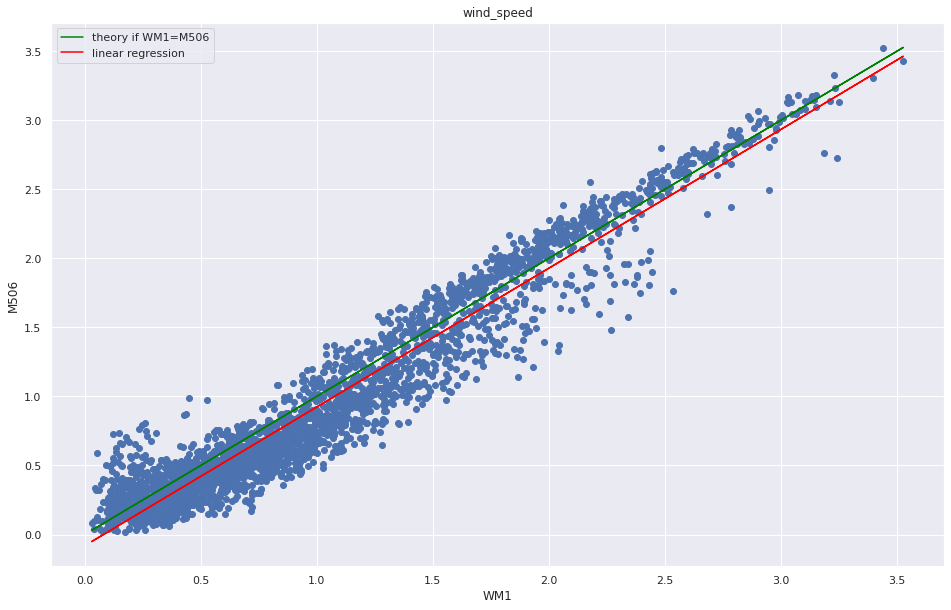

In [ ]:
plot_components_scatter([wm1, m7myr], ('wind_speed', ), figsize=(16,10), plot_info=[{'label': 'WM1'}, {'label': 'M507'}])

## u

In [ ]:
plot_components(resample([wm1, m7myr], '8min'),('u', ), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'u'}, xlabel='date_time'>],
      dtype=object)

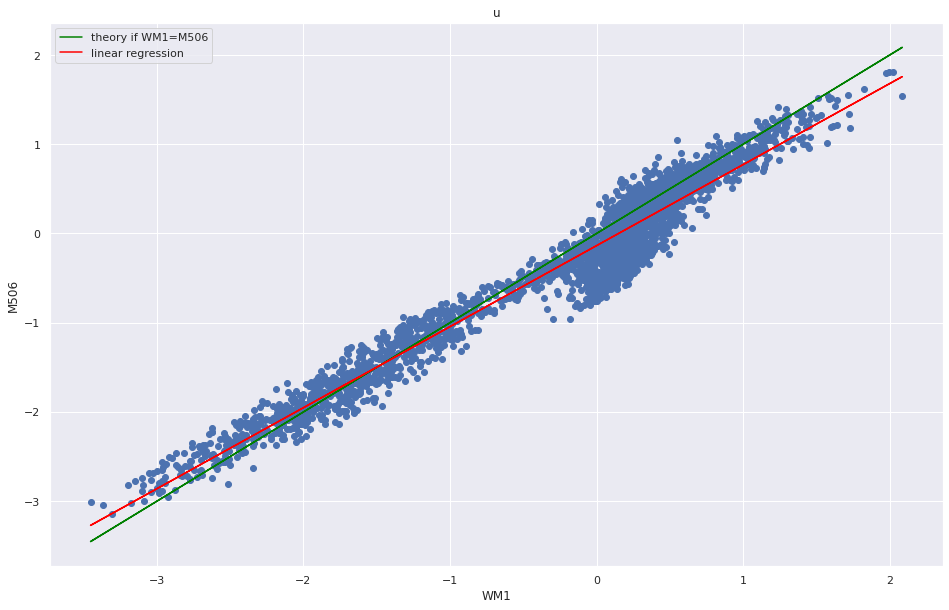

In [ ]:
plot_components_scatter([wm1, m7myr], ('u', ), figsize=(16,10), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

## v

Need to take into account that on the V direction is almost parallel to the mouting structure so there can be interference

In [ ]:
plot_components(resample([wm1, m7myr], '8min'),('v', ), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'v'}, xlabel='date_time'>],
      dtype=object)

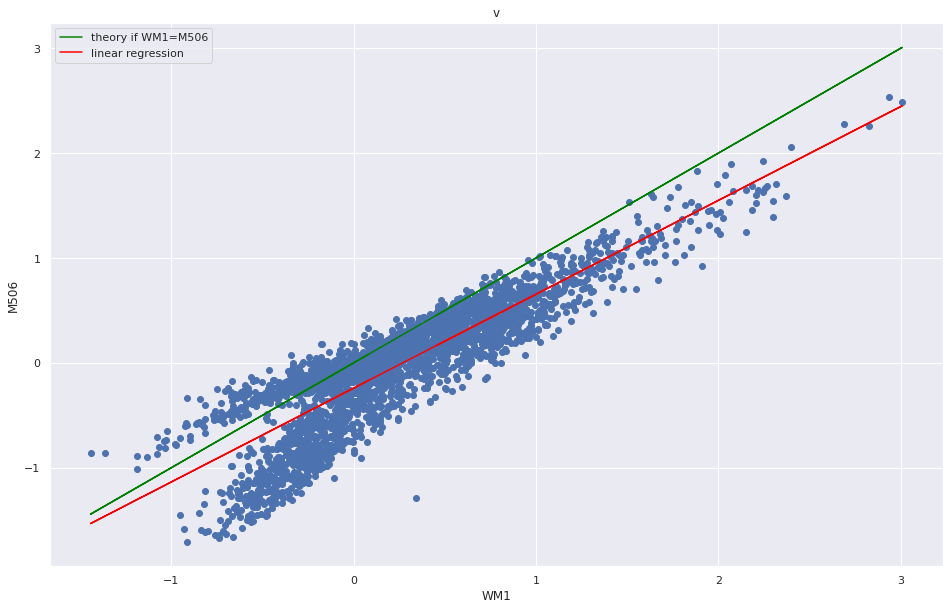

In [ ]:
plot_components_scatter([wm1, m7myr], ('v', ), figsize=(16,10), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

## w

can be worse but still rather bad

In [ ]:
plot_components(resample([wm1, m7myr], '8min'),('w', ), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

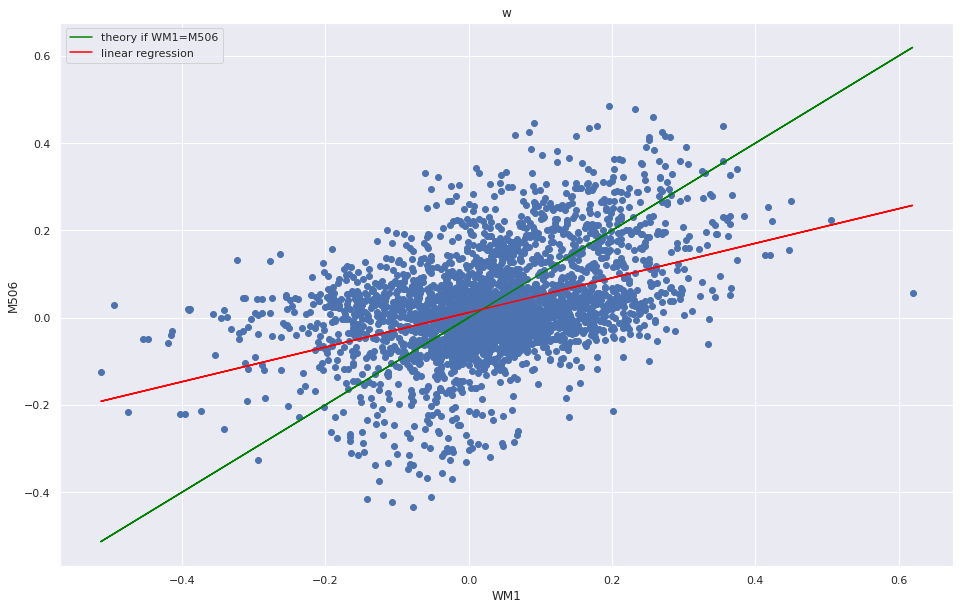

In [ ]:
plot_components_scatter([wm1, m7myr], ('w', ), figsize=(16,10), plot_info=[{'label': 'WM1'}, {'label': 'M506'}])

In [ ]:
plot_components([wm1, m7myr], ['u', 'v', 'w', 'wind_dir'], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'u'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'wind_dir'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
torch.cat([rot2, torch.zeros((1,2))])

tensor([[0.7954, 0.7168],
        [0.3703, 0.7135],
        [0.0000, 0.0000]])

In [ ]:
torch.cat([_,  torch.zeros((3,1))], dim=1)

tensor([[0.7954, 0.7168, 0.0000],
        [0.3703, 0.7135, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [ ]:
wm1.wind_speed.isna().argmax()

1519

# August version

In [ ]:
x = m7rw[['u', 'v', 'w']].to_numpy()

In [ ]:
y_true = wm1r[['u', 'v', 'w']].to_numpy()

In [ ]:
# check what the theory of a euler angles transformation can look like

In [ ]:
theory_ang = [135, 320, 90]

theory_rot = R.from_euler('zyx', theory_ang, degrees=True)

In [ ]:
theory_rot.as_euler('zyx', degrees=True)

array([135., -40.,  90.])

In [ ]:
theory_rot.inv().as_euler('zyx', degrees=True)

array([-140.,   45.,   90.])

In [ ]:
def model(x, angs):
    return R.from_euler('zyx', angs, degrees=True).apply(x)

In [ ]:
def loss(x,y):
    return ((x - y )**2).mean()

TODO add this to wind_tools

In [ ]:
def add_hor_wind_speed(df):
    df['wind_speed_hor'] = wind_speed_comp(df, ['u', 'v'])
    return df

In [ ]:
wm1r = add_hor_wind_speed(wm1r)

In [ ]:
pred = theory_rot.apply(x)

In [ ]:
loss(y_true, pred)

1.321596604252907

In [ ]:
pred

array([[ 0.79350857, -1.19386869, -0.3777923 ],
       [ 0.92990778, -1.26578844, -0.59109389],
       [ 0.90855142, -1.21977987, -0.60476934],
       ...,
       [ 1.79716552, -2.18955407, -0.62677238],
       [ 0.92399413, -1.27861247, -0.42971021],
       [ 0.68458737, -0.92590748, -0.1784384 ]])

In [ ]:
my7 = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
my7.index = m7.index

In [ ]:
my7 = add_hor_wind_speed(my7)

In [ ]:
loss(my7.w, wm1r.w)

0.07343482731851568

In [ ]:
plot_components(resample([wm1r, my7], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
pred2 = theory_rot.inv().apply(x)

In [ ]:
loss(y_true, pred2)

1.3477779115182953

In [ ]:
pred

array([[ 9.98988273e-01, -1.08899730e+00,  1.17527159e-01],
       [ 1.24110802e+00, -1.12937314e+00,  2.25398699e-02],
       [ 1.22642170e+00, -1.08395758e+00,  5.93591837e-04],
       ...,
       [ 2.06937593e+00, -1.97834089e+00,  4.69728743e-01],
       [ 1.14423733e+00, -1.15834007e+00,  1.49114388e-01],
       [ 7.64081786e-01, -8.50661073e-01,  2.24409351e-01]])

In [ ]:
my7_2 = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
my7_2.index = m7.index

In [ ]:
my7_2 = add_hor_wind_speed(my7_2)

In [ ]:
plot_components(resample([wm1r, my7_2], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
rot_opt, *_ = R.align_vectors(x, y_true)

In [ ]:
rot_opt.as_euler('zyx', degrees=True)

array([-37.10652536,  30.66297731, 118.11200375])

In [ ]:
loss(y_true, pred)

0.2603359612393795

In [ ]:
pred

array([[ 9.98988273e-01, -1.08899730e+00,  1.17527159e-01],
       [ 1.24110802e+00, -1.12937314e+00,  2.25398699e-02],
       [ 1.22642170e+00, -1.08395758e+00,  5.93591837e-04],
       ...,
       [ 2.06937593e+00, -1.97834089e+00,  4.69728743e-01],
       [ 1.14423733e+00, -1.15834007e+00,  1.49114388e-01],
       [ 7.64081786e-01, -8.50661073e-01,  2.24409351e-01]])

In [ ]:
pred = rot_opt.apply(x)

In [ ]:
my7_3 = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
my7_3.index = m7.index

In [ ]:
my7_3 = add_hor_wind_speed(my7_3)

In [ ]:
plot_components(resample([wm1r, my7_3], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

NameError: name 'my7_3' is not defined

In [ ]:
model??

Signature: model(x, angs)
Docstring: <no docstring>
Source:   
def model(x, angs):
    return R.from_euler('zyx', angs, degrees=True).apply(x)
File:      ~/Documents/Tesi/trisonica-anemometer-comparison/<ipython-input-25-84e494be4e32>
Type:      function


In [ ]:
pred4 = R.from_euler('xyz', [240, 330, 90], degrees=True).apply(x)

In [ ]:
my7_4 = pd.DataFrame(pred4, columns = ['u', 'v', 'w'])
my7_4.index = m7rw.index

In [ ]:
my7_4 = add_hor_wind_speed(my7_4)

In [ ]:
plot_components(resample([wm1r, my7_4], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
pred4 = R.from_euler('xyz', [240, 330, 90], degrees=True).apply(x)

In [ ]:
my7_4 = pd.DataFrame(pred4, columns = ['u', 'v', 'w'])
my7_4.index = m7rw.index

In [ ]:
my7_4 = add_hor_wind_speed(my7_4)

In [ ]:
plot_components(resample([wm1r, my7_4], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
plot_rotation_steps(v0, [240, 330, 90])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plot_dist_comp([wm1r-my7_4], ('wind_speed_hor', 'w'))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
R.from_euler('xyz', [240, 330, 90], degrees=True).as_euler('zyx', degrees=True)

array([ -90.,  -60., -150.])

### checking that for different rotation of y the w does not change -> cazzata ahaha

In [ ]:
pred = R.from_euler('zyx', [-90, -60, -150], degrees=True).apply(x)

In [ ]:
R.from_euler('zyx', [-90, -60, -150], degrees=True).inv().as_euler('zyx', degrees=True)

array([-90.,  30., 120.])

In [ ]:
loss(pred[:, 2], y_true[:, 2])

1.1356736808331602

In [ ]:
pred = R.from_euler('zyx', [-90, 180, 90], degrees=True).apply(x)

In [ ]:
loss(pred[:, 2], y_true[:, 2])

1.135673680833161

In [ ]:
pred = R.from_euler('zyx', [-90, -60, -150], degrees=True).apply(x)

In [ ]:
loss(pred[:, 2], y_true[:, 2])

0.021477295546251496

In [ ]:
loss(pred, y_true)

0.4285339006335156

In [ ]:
pred = R.from_euler('zyx',np.array([-37.10652536,  30.66297731, 118.11200375]), degrees=True).apply(x)

In [ ]:
loss(y_true, pred)

0.2603359612496714

In [ ]:
### Optmize only the W

## Optimize with constrains to get something that looks reasonable

In [ ]:
from scipy.optimize import LinearConstraint

In [ ]:
def err_range(v, range_=30): return [v-range_, v+range_]

In [ ]:
def my_rot(ang):
    return R.from_euler('zyx', ang, degrees=True)

In [ ]:
theory_ang = np.array(theory_ang)

In [ ]:
linear_constraint = LinearConstraint(np.identity(3), theory_ang-30, theory_ang+30)

In [ ]:
linear_constraint

In [ ]:
loss??

Signature: loss(x, y)
Docstring: <no docstring>
Source:   
def loss(x,y):
    return ((x - y )**2).mean()
File:      ~/Documents/Tesi/trisonica-anemometer-comparison/<ipython-input-26-0e724c375290>
Type:      function


In [ ]:
def rot_func_opt(ang):
    pred = my_rot(ang).apply(x)
    return loss(y_true, pred)

In [ ]:
x0 = theory_ang

res = minimize(rot_func_opt, x0, method='trust-constr',

               constraints=[linear_constraint],

               options={'verbose': 1})

`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 52, CG iterations: 16, optimality: 8.28e-10, constraint violation: 0.00e+00, execution time: 0.055 s.


In [ ]:
res.x

array([105.00094259, 290.00019925,  60.0004332 ])

In [ ]:
pred5 =my_rot([105.00094259, 290.00019925,  60.0004332 ]).apply(x)

In [ ]:
my7_5 = pd.DataFrame(pred5, columns = ['u', 'v', 'w'])
my7_5.index = m7.index

In [ ]:
my7_5 = add_hor_wind_speed(my7_5)

In [ ]:
plot_components(resample([wm1r, my7_5], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
m7rw = add_hor_wind_speed(m7rw)

In [ ]:
wm1r.describe()

,u,v,w,wind_speed,wind_dir,wind_speed_hor
count,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000
mean,-0.266299,0.224963,0.035409,1.033336,167.635421,1.023348
std,1.042373,0.575947,0.126684,0.699422,113.247160,0.701586
min,-3.452527,-1.442855,-0.513217,0.029910,0.237249,0.008209
25%,-1.070503,-0.183106,-0.033588,0.469786,64.111150,0.457186
50%,0.108908,0.132368,0.032833,0.867601,132.446500,0.857373
75%,0.417401,0.590103,0.113996,1.471293,301.721000,1.467400
max,2.085213,3.008783,0.619600,3.527280,359.133000,3.522679


In [ ]:
m7rw.describe()

,u,v,w,wind_speed,wind_dir,wind_speed_hor
count,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000
mean,0.025525,-0.096171,0.217178,0.954594,101.346086,0.924543
std,0.975998,0.568504,0.122907,0.660749,90.296948,0.656203
min,-2.859030,-2.152510,-0.032108,0.039457,0.099878,0.003891
25%,-0.697828,-0.428204,0.120808,0.447945,30.977050,0.423868
50%,0.307414,0.070042,0.198763,0.794188,47.063800,0.762105
75%,0.682954,0.257078,0.293139,1.328020,191.547250,1.294983
max,3.020720,1.541330,1.026130,3.393000,359.985000,3.345434


In [ ]:
plot_components(resample([wm1r, m7rw], '8min'),('wind_speed_hor', 'wind_speed'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>],
      dtype=object)

# ma se la filtro?

In [ ]:
filt = filter_by_wind_dir(wm1r, 250, 10)

In [ ]:
wm1f = wm1r[filt]

In [ ]:
m7f =m7rw[filt]

In [ ]:
loss(wm1f.wind_speed, m7f.wind_speed)

0.021606351835399818

In [ ]:
loss(wm1.wind_speed, m7.wind_speed)

0.0819900083446558

abbiamo capito che la roba filtrata  é piú bella....

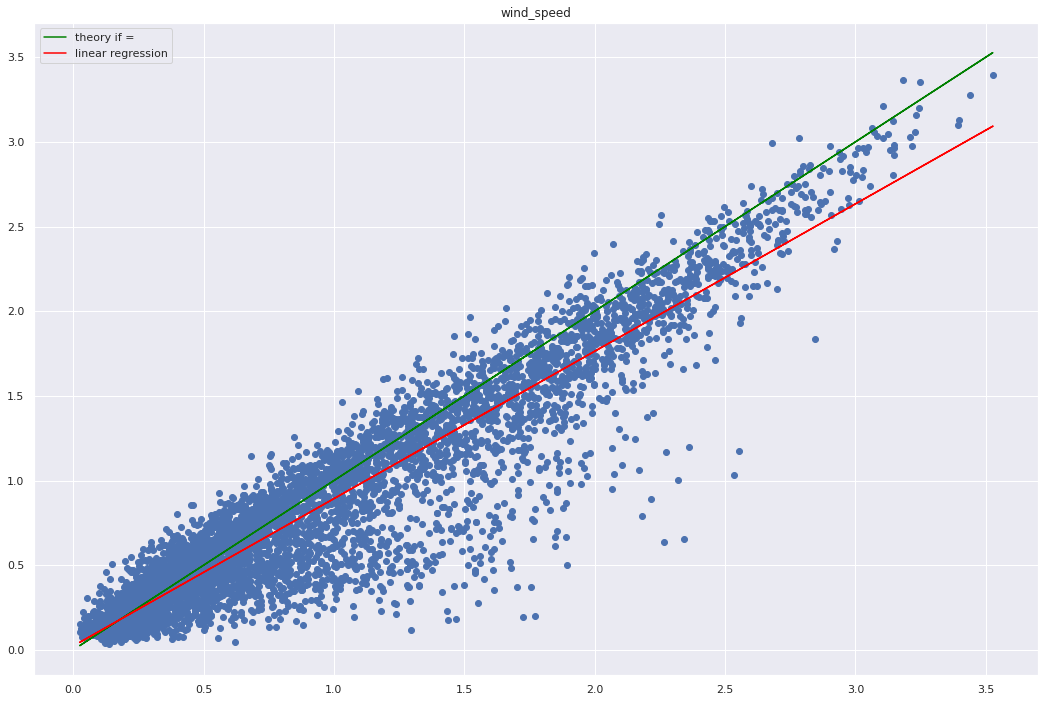

In [ ]:
plot_components_scatter([wm1r, m7rw],['wind_speed'], figsize=(18,12))

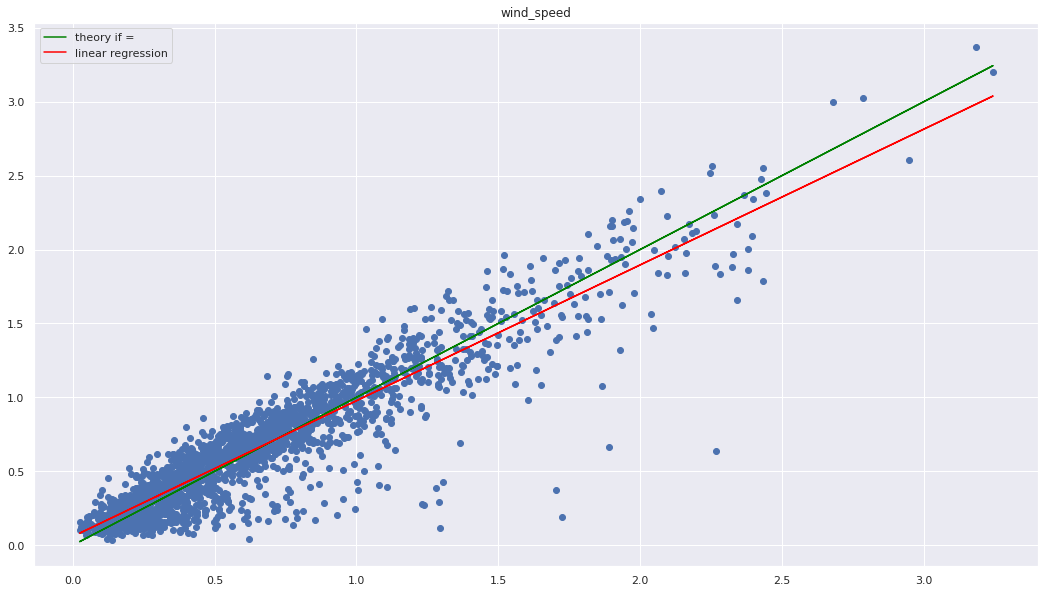

In [ ]:
plot_components_scatter([wm1f, m7f] ,['wind_speed'], figsize=(18,10), linreg=True)

### old optmization works for new data??? 

In [ ]:
rot_data = my_rot([ -90.,  -60., -150.]).apply(m7rw[['u', 'v', 'w']].to_numpy())

In [ ]:
m7my = pd.DataFrame(rot_data, columns=['u', 'v', 'w'])
m7my.index = m7rw.index

m7my = add_wind_speed(m7my)

In [ ]:
%matplotlib widget

In [ ]:
plot_components(resample([wm1, m7my], '8min') ,['wind_speed', 'w', 'v', 'u'], figsize=(18,18), vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'u'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
rot_dataf = my_rot([ -90.,  -60., -150.]).apply(m7f[['u', 'v', 'w']].to_numpy())

In [ ]:
m7myf = pd.DataFrame(rot_dataf, columns=['u', 'v', 'w'])
m7myf.index = m7f.index

m7myf = add_wind_speed(m7myf)

In [ ]:
plot_components(resample([wm1f, m7myf], '8min') ,['wind_speed', 'w', 'v', 'u'], figsize=(18,14), vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'u'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
loss(wm1.w, m7my.w)

0.021487690715564473

In [ ]:
loss(wm1f.w, m7myf.w)

0.007822377009235201

In [ ]:
axes = plot_components(resample([wm1, m7my], '8min') ,['w'], figsize=(18,10), vertical=False)
axes[0].bar(wm1f.index, 1, width=3, edgecolor='green')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<BarContainer object of 585 artists>

In [ ]:
plot_components_scatter([wm1f, m7myf] ,['wind_speed', 'w', 'v', 'u'], figsize=(18,10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
from pyCompare import blandAltman

In [ ]:
blandAltman(wm1.wind_speed, m7my.wind_speed,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
blandAltman(wm1f.w, m7myf.w,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
blandAltman?

Signature:
blandAltman(
    data1,
    data2,
    limitOfAgreement=1.96,
    confidenceInterval=95,
    confidenceIntervalMethod='approximate',
    percentage=False,
    detrend=None,
    title=None,
    figureSize=(10, 7),
    dpi=72,
    savePath=None,
    figureFormat='png',
    meanColour='#6495ED',
    loaColour='coral',
    pointColour='#6495ED',
)
Docstring:
blandAltman(data1, data2, limitOfAgreement=1.96, confidenceInterval=None, **kwargs)

Generate a Bland-Altman [#]_ [#]_ plot to compare two sets of measurements of the same value.

Confidence intervals on the limit of agreement may be calculated using:
- 'exact paired' uses the exact paired method described by Carkeet [#]_
- 'approximate' uses the approximate method described by Bland & Altman

The exact paired method will give more accurate results when the number of paired measurements is low (approx < 100), at the expense of much slower plotting time.

The *detrend* option supports the following options:
- ``None`` do not 

# Plotting vectors and the theory

## defining the basic funcs

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import itertools
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [ ]:
# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [ ]:
color_cycle = ['r', 'g', 'b', 'y', 'm']
def plot_vecs3d(vecs, colors=color_cycle, ax=None, lw=3):
    
    ax = ax or  plt.figure().add_subplot(111, projection='3d')    
    ax.set_xlim3d(min(vecs[:, 0].min(), -1), max(vecs[:, 0].max(), 1))
    ax.set_ylim3d(min(vecs[:, 1].min(), -1), max(vecs[:, 1].max(), 1))
    ax.set_zlim3d(min(vecs[:, 2].min(), -1), max(vecs[:, 2].max(), 1))
    ax.plot(0,0,0) #origin
    for vec, color in zip(vecs, itertools.cycle(colors)):
        a = Arrow3D([0, vec[0]], [0,vec[1]], [0, vec[2]], mutation_scale=20, 
                lw=lw, arrowstyle="-|>", color=color)
        ax.add_artist(a)
    plt.draw()
    return ax

In [ ]:
axis_conv = {'x': 0, 'y': 1, 'z': 2}
def plot_vecs2d(vecs, plane='xy', colors=color_cycle, ax=None, lw=3):
    select = [axis_conv[plane[0]], axis_conv[plane[1]]]
    ax = ax or  get_ax()
    
    ax.set_xlim(min(vecs[:, select[0]].min(), -1) - .2, max(vecs[:, select[0]].max(), 1) +.2)
    ax.set_ylim(min(vecs[:, select[1]].min(), -1) - .2, max(vecs[:, select[1]].max(), 1) +.2)
    
    for vec, color in zip(vecs, itertools.cycle(colors)):
        ax.arrow(0,0, vec[select[0]], vec[select[1]], color=color, lw=lw)
    ax.set_xlabel(plane[0])
    ax.set_ylabel(plane[1])
    return ax
    

In [ ]:
def plot_rotation_steps(v0, angs, euler='xyz', figsize=(18,16)):
    rot_ang = np.array([0,0,0])
    fig = plt.figure(figsize=figsize)
    vecs = [v0]
    
    for i in range(3):
        rot_ang[i] = angs[i]
        
        vecs.append(R.from_euler(euler, rot_ang, degrees=True).apply(v0))
        
        ax=fig.add_subplot(2,2,i+1, projection='3d')
        ax.set_title(f"adding a rotation on {euler[i]} of {angs[i]} rotation of {rot_ang}")
        plot_vecs3d(vecs[i+1], colors=['r', 'g', 'b'], ax=ax, lw=5)
        plot_vecs3d(vecs[i], colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # mark the old position
    
    ax = fig.add_subplot(224, projection='3d')
    ax.set_title("original vs final")
    plot_vecs3d(R.from_euler(euler, angs, degrees=True).apply(v0), colors=['r', 'g', 'b'], ax=ax, lw=5 )
    plot_vecs3d(v0, colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one
        
        

In [ ]:
v0 = np.array([[1,0,0], [0,1,0], [0,0,1]])

In [ ]:
fig, ax = plt.subplots()
vecs= np.array([[1,1,0], [0,1,1]])
plot_vecs2d(vecs, plane='xy',  ax=fig.add_subplot(121))
plot_vecs3d(vecs, ax=fig.add_subplot(122, projection='3d'))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

capiamo ste cavolo di rotazioni

In [ ]:
v1 = R.from_euler('xyz', [135, 220, 90], degrees=True).apply(v0)

In [ ]:
plot_vecs3d(np.concatenate([v0, v1]), colors=['r', 'g', 'b'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Axes3DSubplot:>

In [ ]:
v1 = R.from_euler('xyz', [240, 330, 90], degrees=True).apply(v0)

In [ ]:
plot_vecs3d(np.concatenate([v0, v1]), colors=['r', 'g', 'b'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Axes3DSubplot:>

In [ ]:
plt.tight_layout()

In [ ]:
def apply_rotation_on_data(ang, seq='XYZ'):
    rotation = R.from_euler(seq, ang, degrees=True)
    x = m7rw[['u', 'v', 'w']].to_numpy()
    pred = rotation.apply(x)

    m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
    m7r.index = m7rw.index

    m7r = add_hor_wind_speed(m7r)
    return m7r
    

## is time to look at the data

In [ ]:
plot_rotation_steps(v0, [240, 330, 90], euler='xyz')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
(330+310)%360

280

In [ ]:
m7myr = pd.DataFrame(model(x, [240, 330, 90]), columns=list('uvw'))
m7myr.index = m7rw.index

In [ ]:
plot_components(resample([wm1, m7r], '8min'),('u', 'v', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507'}], vertical=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'u'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
plot_components(resample([wm1r, apply_rotation_on_data([250., 340., 320.])], '8min'),('u', 'v', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507'}], vertical=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'u'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'v'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
plot_rotation_steps(v0, [240, 0, 90])
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
225-180

45

#### sssshhh maybe we found something interesting

In [ ]:
the_number = [240, 330, 90]

the_rotation = R.from_euler('xyz', the_number, degrees=True)

the_pred = the_rotation.apply(x)

the_m7 = pd.DataFrame(the_pred, columns = ['u', 'v', 'w'])
the_m7.index = m7rw.index

wm1r = add_hor_wind_speed(wm1r)

the_m7 = add_hor_wind_speed(the_m7)

plot_components(resample([wm1r, the_m7], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': 'M507'}], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

## what happens with the theory of rotations

In [ ]:
v0 = np.array([[1,0,0], [0,1,0], [0,0,1]])

In [ ]:
plot_rotation_steps(v0, [90, 220, 45], euler='XYZ')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plot_rotation_steps(v0, [0, 90, 180], euler='XYZ')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
[90, 0, 45], euler='XYZ'

In [ ]:
ang = [90, 220, -135]
seq='XYZ'

rotation = R.from_euler(seq, ang, degrees=True)
x = m7rw[['u', 'v', 'w']].to_numpy()
x[:, 0] = - x[:,0]
pred = rotation.apply(x)

m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
m7r.index = m7rw.index

m7r = add_hor_wind_speed(m7r)

axes = plot_components(resample([wm1r, m7r], '8min'),('wind_speed_hor', 'w', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507 with rotation {ang} on {seq}'}], vertical=False)
axes[2].bar(wm1f.index, 1, width=3, edgecolor='green')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<BarContainer object of 585 artists>

In [ ]:
ang = [  99.,    0., -147.]
seq='XYZ'

rotation = R.from_euler(seq, ang, degrees=True)
x = m7rw[['u', 'v', 'w']].to_numpy()
x[:, 0] = - x[:,0]
pred = rotation.apply(x)

m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
m7r.index = m7rw.index

m7r = add_hor_wind_speed(m7r)

axes = plot_components(resample([wm1r, m7r], '8min'),('wind_speed_hor', 'w'), plot_info=[{'label': 'WM1'}, {'label': f'M507 with rotation {ang} on {seq}'}], vertical=False)
# axes[2].bar(wm1f.index, 1, width=3, edgecolor='green')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ang = [  99.,  0., -147.]
seq='XYZ'

rotation = R.from_euler(seq, ang, degrees=True)
x = m7rw[['u', 'v', 'w']].to_numpy()
pred = rotation.apply(x)

m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
m7r.index = m7rw.index

m7r = add_hor_wind_speed(m7r)

axes = plot_components(resample([wm1r, m7r], '8min'), plot_info=[{'label': 'WM1'}, {'label': f'M507 with rotation {ang} on {seq}'}], vertical=False)
# axes[2].bar(wm1f.index, 1, width=3, edgecolor='green')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
ang = [  90,    200., -145]
seq='XYZ'

rotation = R.from_euler(seq, ang, degrees=True)
x = m7rw[['u', 'v', 'w']].to_numpy()
x[:, 0] = - x[:,0]
pred = rotation.apply(x)

m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
m7r.index = m7rw.index

m7r = add_hor_wind_speed(m7r)

axes = plot_components(resample([wm1r, m7r], '8min'), plot_info=[{'label': 'WM1'}, {'label': f'M507 with rotation {ang} on {seq}'}], vertical=False)
# axes[2].bar(wm1f.index, 1, width=3, edgecolor='green')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

dammmmmm

In [ ]:
import itertools

In [ ]:
results.argmin()

1353

In [ ]:
test_angles[1353]

array([  99.,    0., -147.])

In [ ]:
w_mse(model((80.0, 0, -170.0)), y_true)

In [ ]:
results

array([1.89954113, 1.86793587, 1.83603805, ..., 0.28700791, 0.28265524,
       0.27896977])

In [ ]:
plot_rotation_steps(v0, [80, 0, -100], euler='XYZ')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plot_rotation_steps(v0, [90, 220, -135], euler='XYZ')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### brute force with intric angles

In [ ]:
def mse(x,y):
    return ((x- y)**2).mean()

In [ ]:
X_angs = np.arange(0, 360, 10, dtype=float)
Y_angs = np.arange(0, 360, 10, dtype=float)
Z_angs = np.arange(0, 360, 10, dtype=float)

In [ ]:
results = np.zeros((X_angs.shape[0]*Y_angs.shape[0]*Z_angs.shape[0],), dtype=float)

In [ ]:
test_angles = np.array(list(itertools.product(X_angs,Y_angs, Z_angs)))

In [ ]:
x= m7rw[['u', 'v', 'w']].to_numpy()
y_truer = wm1r[['u', 'v', 'w']].to_numpy()

In [ ]:
def model(ang):
    return R.from_euler('XYZ', ang).apply(x)

In [ ]:
def ugly_optimize():
    for i, angs in enumerate(test_angles):
        pred = model(angs)
        results[i] = mse(y_truer, pred)

In [ ]:
ugly_optimize()

In [ ]:
test_angles[results.argmin()]

array([ 70., 200., 140.])

In [ ]:
test_angles[pd.Series(results).nsmallest(10).index]

array([[ 70., 200., 140.],
       [250., 340., 320.],
       [ 80., 200., 140.],
       [260., 340., 320.],
       [ 60., 200., 140.],
       [240., 340., 320.],
       [ 90., 200., 140.],
       [270., 340., 320.],
       [270., 340., 330.],
       [ 90., 200., 150.]])

In [ ]:
pd.Series(results).nsmallest(10)

9806     0.084660
33656    0.084660
11102    0.086306
34952    0.086306
8510     0.086331
32360    0.086331
12398    0.091220
36248    0.091220
36249    0.091239
12399    0.091239
dtype: float64

In [ ]:
R.from_euler('xyz', [240, 330, 90]).as_euler('XYZ', degrees=True)

array([-150.,  -60.,  -90.])

In [ ]:
plot_rotation_steps(v0, [ 40., 240., 100.], euler='XYZ')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Theory application are equal to axis swapping?

Dajeeee funziona

In [ ]:
ang = [  -90,    0., -135]
seq='XYZ'
rotation = R.from_euler(seq, ang, degrees=True)
x = m7rw[['u', 'v', 'w']].to_numpy()

pred = rotation.apply(x)

m7r = pd.DataFrame(pred, columns = ['u', 'v', 'w'])
m7r.index = m7rw.index

m7r = m7.pipe(add_hor_wind_speed).pipe(add_wind_speed).pipe(add_wind_dir)

In [ ]:
m7r.describe()

,u,v,w
count,5190.000000,5190.000000,5190.000000
mean,-0.011507,0.219262,-0.205633
std,0.323138,0.125435,1.016520
min,-1.375160,-0.032108,-3.290967
25%,-0.207269,0.119908,-1.039742
50%,-0.034885,0.198658,0.162415
75%,0.221819,0.297619,0.499335
max,1.192359,1.026130,2.896783


In [ ]:
m7.describe()

,u,v,w,wind_speed,wind_dir
count,2943.000000,2943.000000,2943.000000,2943.000000,2943.000000
mean,-0.085237,0.216038,-0.035999,0.927383,265.157157
std,0.349051,0.120587,1.020465,0.607251,91.693849
min,-1.316930,-0.032108,-3.023360,0.039933,0.051559
25%,-0.312059,0.121321,-0.811441,0.448180,261.863500
50%,-0.099550,0.198646,0.299750,0.792777,278.356000
75%,0.143134,0.291913,0.649817,1.316170,317.748500
max,1.193280,0.914108,2.492670,3.043640,359.905000


In [ ]:
u,v,w = 0,1,2
def process_m507(data):
    
    new_data = np.empty_like(data)
    data[:, [u, v]] = rotate_ang(data[:, [u,v]], 45)
    
    new_data[:, u] = -1 * data[:, u]
    new_data[:, v] = data[:, w]
    new_data[:, w] = data[:, v]
    
    return new_data

In [ ]:
v0 = np.eye(3)

In [ ]:
v0_m507 = process_m507(v0.copy())

In [ ]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.set_title("original vs final")
plot_vecs3d(v0_m507, colors=['r', 'g', 'b'], ax=ax, lw=5 )
plot_vecs3d(rotation.apply(v0), colors=['fuchsia', 'yellow', 'cyan'], ax=ax, lw=2) # plot origins as reference only on the last one


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Axes3DSubplot:title={'center':'original vs final'}>

need to rotate on y axis before....

In [ ]:
plot_components(resample([wm1r, m7r], '8min'), ['wind_speed_hor', 'w', 'wind_speed'], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'wind_speed'}, xlabel='date_time'>],
      dtype=object)

In [ ]:
rotate_ang(v0[:, [0,1]] , 45)

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
v0[:, [0,1]] 

array([[0, 0],
       [0, 0],
       [0, 0]])

In [ ]:
v0

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
m7r

,u,v,w,wind_speed_hor
date_time,,,,
2020-07-24 13:02:00,0.655471,-0.597669,1.187794,0.887046
2020-07-24 13:04:00,0.895447,-0.581613,1.294698,1.067754
2020-07-24 13:06:00,0.899273,-0.552887,1.250879,1.055641
2020-07-24 13:08:00,0.766090,-0.530915,1.078160,0.932076
2020-07-24 13:10:00,1.132517,-0.540395,1.196298,1.254840
...,...,...,...,...
2020-07-31 17:52:00,0.766238,-0.685794,1.564987,1.028316
2020-07-31 17:54:00,1.074077,-0.877108,2.239707,1.386708
2020-07-31 17:56:00,1.070235,-0.725708,1.698303,1.293080


In [ ]:
# Find a nice rotation

In [ ]:
check_rotation_data([90, 220, 45])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### brute force with limitations

In [ ]:
def w_mse(x,y):
    return ((x[:, 2]- y[:, 2])**2).mean()

In [ ]:
def mse(x,y):
    return ((x[:, 0]- y[:, 0])**2).mean()

In [ ]:
X_angs = np.arange(-100, -80, dtype=float)
Y_angs = np.array([0])
Z_angs = np.arange(-170, -100, dtype=float)

In [ ]:
x1 = m7rw[['u', 'v', 'w']].to_numpy()
y_true = wm1[['u', 'v', 'w']].to_numpy()

In [ ]:
Y_angs.shape

(1,)

In [ ]:
results = pd.Series(np.zeros((X_angs.shape[0]*Y_angs.shape[0]*Z_angs.shape[0],), dtype=float))

In [ ]:
test_angles = np.array(list(itertools.product(X_angs,Y_angs, Z_angs)))

In [ ]:
def model(ang):
    return R.from_euler('XYZ', ang).apply(x)

In [ ]:
def ugly_optimize(x,y,z):
    for i, angs in enumerate(itertools.product(x,y,z)):
        pred = model(angs)
        results[i] = mse(y_true, pred)

In [ ]:
ugly_optimize(X_angs, Y_angs, Z_angs)

In [ ]:
results.nsmallest(50)

69      0.278970
139     0.278970
209     0.278970
279     0.278970
349     0.278970
419     0.278970
489     0.278970
559     0.278970
629     0.278970
699     0.278970
769     0.278970
839     0.278970
909     0.278970
979     0.278970
1049    0.278970
1119    0.278970
1189    0.278970
1259    0.278970
1329    0.278970
1399    0.278970
1258    0.282655
68      0.282655
138     0.282655
208     0.282655
278     0.282655
348     0.282655
418     0.282655
488     0.282655
558     0.282655
628     0.282655
698     0.282655
768     0.282655
838     0.282655
908     0.282655
978     0.282655
1048    0.282655
1118    0.282655
1188    0.282655
1328    0.282655
1398    0.282655
67      0.287008
137     0.287008
207     0.287008
277     0.287008
347     0.287008
417     0.287008
487     0.287008
557     0.287008
627     0.287008
697     0.287008
dtype: float64

In [ ]:
test_angles[results.nsmallest(10).index]

array([[-100.,    0., -101.],
       [ -99.,    0., -101.],
       [ -98.,    0., -101.],
       [ -97.,    0., -101.],
       [ -96.,    0., -101.],
       [ -95.,    0., -101.],
       [ -94.,    0., -101.],
       [ -93.,    0., -101.],
       [ -92.,    0., -101.],
       [ -91.,    0., -101.]])

In [ ]:
plot_components(resample([wm1r, apply_rotation_on_data([-100.,    0., -101.])], '8min'), ['wind_speed_hor', 'w'], vertical=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'wind_speed_hor'}, xlabel='date_time'>,
       <AxesSubplot:title={'center':'w'}, xlabel='date_time'>],
      dtype=object)

### Check inverse rotation

In [ ]:
   [90,  0., -145]

## Work with real wind vecs 

# previous experiments

In [ ]:
# fill NaN value on the 26th at 15:40
wm1 = wm1.interpolate()

In [ ]:
plot_components_scatter([wm1, m7], ('wind_speed',))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plot_dist_comp(wm1)
plot_dist_comp(m7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:ylabel='Frequency'>

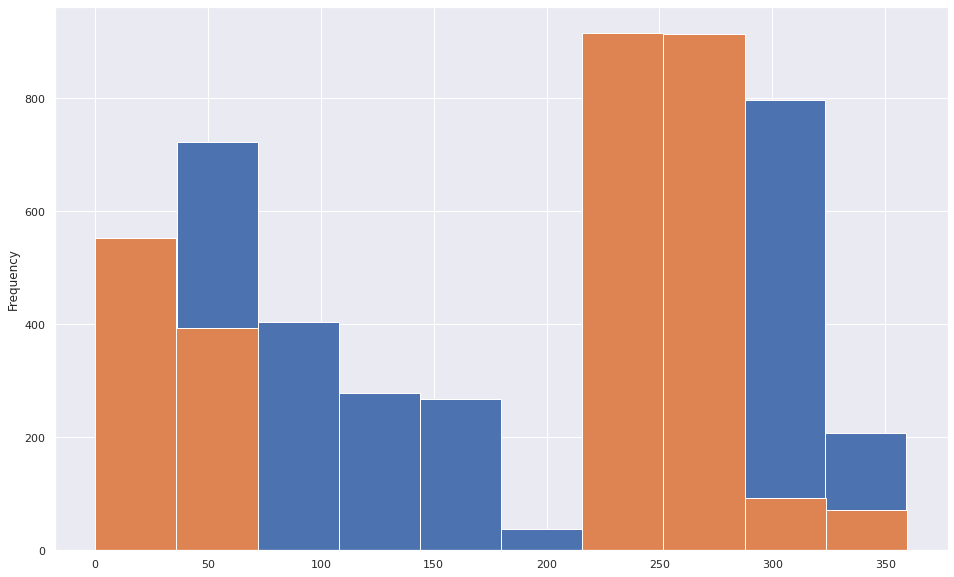

In [ ]:
wm1.wind_dir.plot.hist()
m7.wind_dir.plot.hist()

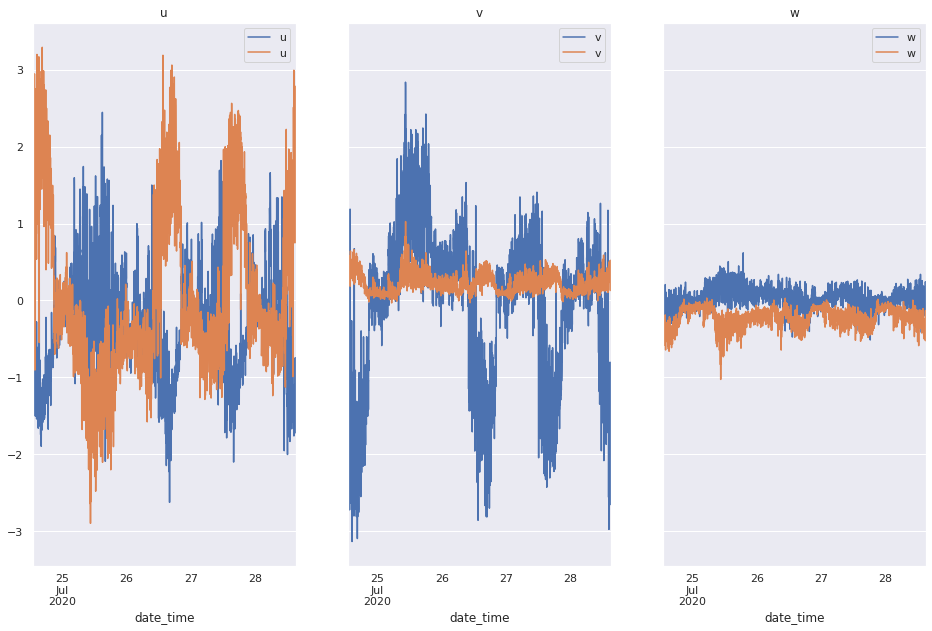

In [ ]:
plot_components([wm1, m7])

In [ ]:
m7i = m7
m7i.u = -m7i.u
m7i.w = -m7i.w

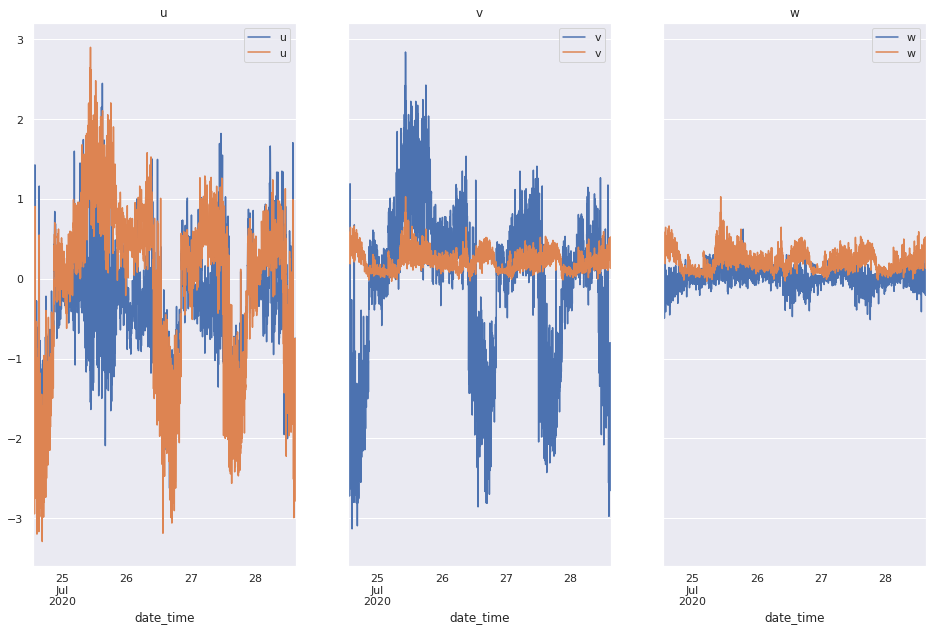

In [ ]:
plot_components([wm1, m7i])

## filter by wind_dir

In [ ]:
filt = filter_by_wind_dir(wm1, 230, 30)

In [ ]:
wm1.index

DatetimeIndex(['2020-07-24 13:02:00', '2020-07-24 13:04:00',
               '2020-07-24 13:06:00', '2020-07-24 13:08:00',
               '2020-07-24 13:10:00', '2020-07-24 13:12:00',
               '2020-07-24 13:14:00', '2020-07-24 13:16:00',
               '2020-07-24 13:18:00', '2020-07-24 13:20:00',
               ...
               '2020-07-28 14:42:00', '2020-07-28 14:44:00',
               '2020-07-28 14:46:00', '2020-07-28 14:48:00',
               '2020-07-28 14:50:00', '2020-07-28 14:52:00',
               '2020-07-28 14:54:00', '2020-07-28 14:56:00',
               '2020-07-28 14:58:00', '2020-07-28 15:00:00'],
              dtype='datetime64[ns]', name='date_time', length=2940, freq=None)

In [ ]:
wm1f = wm1[filt]
m7f = m7[filt]

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



<AxesSubplot:xlabel='date_time'>

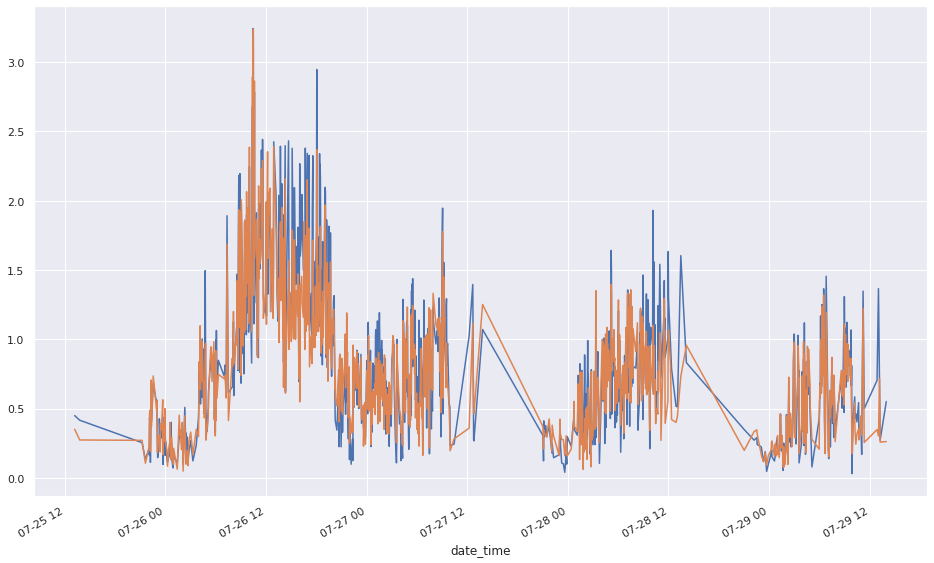

In [ ]:
wm1f.wind_speed.plot()
m7f.wind_speed.plot()

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/home/simone/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning:


The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.



<AxesSubplot:xlabel='date_time'>

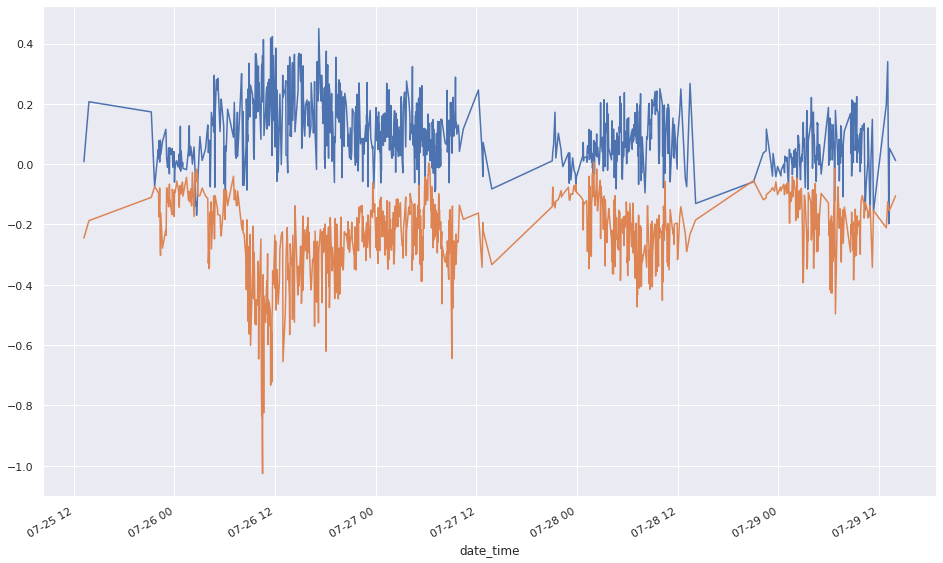

In [ ]:
wm1f.w.plot()
m7f.w.plot()